# **ARE YOU ALL STARS MATERIAL?**

In this notebook, we will explore whether a player with certain stats is All-Stars material or not using a machine learning approach. We will start by gathering and preparing our dataset, which consists of comprehensive statistics of NBA players, both current and past. This data has been meticulously collected and verified by our team from the official [NBA website](https://www.nba.com/).

We will then proceed with data preprocessing, feature selection, and model training to predict the likelihood of a player being an All-Star. Let's dive into the exciting world of basketball analytics and machine learning!

First of all, we import the necessary dependencies.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_fscore_support

We then convert each csv to dataframes using Pandas and then combining the non all-star players.

In [29]:
all_stars_df = pd.read_csv('players_dataset/All_Stars.csv', header=0)
atlantic_df = pd.read_csv('players_dataset/Atlantic.csv', header=0)
central_df = pd.read_csv('players_dataset/Central.csv', header=0)
northwest_df = pd.read_csv('players_dataset/Northwest.csv', header=0)
pacific_df = pd.read_csv('players_dataset/Pacific.csv', header=0)
southeast_df = pd.read_csv('players_dataset/Southeast.csv', header=0)
southwest_df = pd.read_csv('players_dataset/Southwest.csv', header=0)

divisions = [southwest_df, southeast_df, pacific_df, northwest_df, central_df, atlantic_df]
non_all_star_df = pd.concat(divisions, ignore_index=True)

Assign binary labels for all-stars and non all-stars. In our case, 1 denotes all-star, 0 denotes otherwise.

In [30]:
all_stars_df["Label"] = 1  # All-Star
non_all_star_df["Label"] = 0  # Non-All-Star

all_players_df = pd.concat([all_stars_df, non_all_star_df], ignore_index=True)

Then, we clean up the data and make sure Python can read each category correctly. E.g., the player's height is still in feet and inches format, we'd have to make sure that Python can read it as inches (with number type). For simplicity in code, we used Regex.

In [31]:
# Extract the numerical value of the weight, removing the "lbs" suffix
all_players_df["Weight"] = all_players_df["Weight"].str.extract(r'(\d+)').astype(float)

# Converting the height to inches from feet and inches format
height_split = all_players_df["Height"].str.extract(r'(?P<feet>\d+)\'(?P<inches>\d+)')
all_players_df["Height"] = height_split["feet"].astype(float) * 12 + height_split["inches"].astype(float)

## Distance Metrics
Before we build our classifiers, let's first define the different distance metrics we will use to measure similarity between data points. These metrics help determine how "close" two players are based on their stats. We'll be using 3 different metrics for comparison:
1. Cosine Similarity
2. Euclidean distance
3. Mahalanobis distance
<br>

### Cosine Similarity
Cosine similarity measures the similarity between two vectors based on the angle between them. Cosine similarity measures the similarity between two vectors based on the angle between them. It is useful when the magnitude of the values does not matter, only their direction (e.g., comparing player performance trends rather than raw numbers). We use numpy's extensive mathematical functions for this.

In [32]:
def cosine_similarity(v1, v2):
    """Calculate cosine similarity between two vectors. The cosine similarity is a measure of similarity between two non-zero vectors of an inner product."""
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

### Euclidean Distance
Euclidean distance measures the straight-line distance between two points in feature space. It is the most commonly used metric for KNN as it treats all features equally.

In [33]:
def euclidean_distance(v1, v2):
    """Calculate euclidean distance between two vectors. For every dimension, calculate the difference between the two vectors, square it, sum all the squared differences, and take the square root of the sum."""
    return np.sqrt(np.sum((np.array(v1) - np.array(v2))**2))

### Mahalanobis Distance
Mahalanobis distance accounts for correlations between variables and scales the distances accordingly. Mahalanobis distance accounts for correlations between variables and scales the distances accordingly. It is particularly useful when features (e.g., height and weight) are correlated. In this case, we use a library to get the mahalanobis distance (just so that they can handle the matrix multiplication behind the scenes). Our function definition helps with inverting the covariance matrix before using the library's function.

In [34]:
def mahalanobis_distance(v1, v2, cov_matrix):
    """Calculate the Mahalanobis distance between two vectors. The Mahalanobis distance is a measure of the distance between a point and a distribution."""
    inv_cov = np.linalg.inv(cov_matrix)
    return mahalanobis(v1, v2, inv_cov)

## K-Nearest Neighbour

Now that all data is tidy and clean, we start with training the model using K-Nearest Neighbour (KNN). KNN is a supervised machine learning algorithm used for classification and regression. It works by finding the k closest points (neighbors) to a given data point and assigning a label based on the majority vote of those neighbors.

Before applying KNN, we need to split our dataset into a **training set** and a **test set**. The training set is used to teach the model, while the test set evaluates its performance.

In [35]:
# Let x = features
# player_features stores an array of arrays of features of all players
player_features = all_players_df[["Height", "Weight", "PPG (Points per game)", "RPG (Rebound per game)", "APG (Assists per game)", "PIE (Player Impact Estimate)"]]

# Let y = labels
# player_labels stores an array of labels (1 or 0, all-stars or not) of all players
player_labels = all_players_df["Label"]

# player_names stores an array of names of all players
player_names = all_players_df["Name"]

# Perform train-test split with 75% training data and 25% testing data and keeping names to identify players
x_train, x_test, y_train, y_test, train_name, test_name = train_test_split(player_features, player_labels, player_names, test_size=0.3, random_state=42)

# Get the covariance matrix of the training data
cov_matrix = np.cov(x_train.T)

Now, let's create a function to predict labels using KNN with different distance metrics. Here's how we implemented this manually:

1. **Initialization**: Choose the number of neighbors `k` and a distance metric (e.g., Euclidean, Cosine, Mahalanobis).

2. **Distance Calculation**: For a new data point, calculate the distance between this point and all points in the training set using the chosen distance metric.

3. **Sorting**: Sort the calculated distances in ascending order (or descending)—according to the metrics chosen.

4. **Neighbor Selection**: Select the top `k` closest points (neighbors) from the sorted list.

5. **Voting**: Count the labels of the selected `k` neighbors. The label with the highest count is the predicted label for the new data point.

6. **Prediction**: Assign the predicted label to the new data point.

In [36]:
def knn_prediction(x_train, y_train, x_test, k, metric, cov_matrx=None):
    """A K-Nearest Neighbors classifier that predicts the label of the test data based on the training data and a distance metric."""
    predictions = []
    for test_point in x_test:
        distances = []
        for i, train_point in enumerate(x_train):
            if metric == 'cosine':
                distance = cosine_similarity(test_point, train_point)
            elif metric == 'euclidean':
                distance = euclidean_distance(test_point, train_point)
            elif metric == 'mahalanobis':
                distance = mahalanobis_distance(test_point, train_point, cov_matrix)
            distances.append((distance, y_train[i]))
        
        # Sort the distances and get the k-nearest neighbors, if cosine similarity, sort in descending order to get the largest values
        distances.sort(reverse=(1 if metric == 'cosine' else 0))
        k_neighbours = [label for j, label in distances[:k]]

        # Predict the label of the test point based on the majority label of the k-nearest neighbors
        prediction = 1 if k_neighbours.count(1) > k_neighbours.count(0) else 0
        predictions.append(prediction)

    return predictions

Now, we perform all 3 metrics on our dataset and evaluate the model using accuracy and precision to determine how well it performs mathematically. The following is how we calculated our performance metrics:
1. **Accuracy**: How often the model predicts correctly. [$\frac{True\:Positives\:+\:True\:Negatives}{Number\:of\:Samples}$]
<br><br>
2. **Precision**: How many predicted positives are correct. [$\frac{True\:Positives}{True\:Positives\:+\:False\:Positives}$]

In [37]:
def calculate_accuracy(y_test, y_pred):
    """Calculate the accuracy of the model."""
    true_positives = true_negatives = 0
    for i in range(len(y_test)):
        if y_test[i] == 1 and y_pred[i] == 1:
            true_positives += 1
        elif y_test[i] == 0 and y_pred[i] == 0:
            true_negatives += 1
    
    return (true_positives + true_negatives) / len(y_test)

def calculate_precision(y_test, y_pred):
    """Calculate the precision of the model."""
    true_positives = positives = 0
    for i in range(len(y_test)):
        if y_test[i] == 1 and y_pred[i] == 1:
            true_positives += 1
        if y_test[i] == 1:
            positives += 1
        
    # Used max() to prevent zero division error
    return true_positives / max((positives), 1)

def get_knn_results(x_train, y_train, x_test, y_test, k_values, cov_matrix=None):
    """Get the K-Nearest Neighbors results for a given k and distance metric."""
    for k in k_values:
        print(f"-----K = {k}-----")
                
        cosine_pred = knn_prediction(x_train, y_train, x_test, k, 'cosine')
        euclidean_pred = knn_prediction(x_train, y_train, x_test, k, 'euclidean')
        mahalanobis_pred = knn_prediction(x_train, y_train, x_test, k, 'mahalanobis', cov_matrix)

        cosine_accuracy = calculate_accuracy(y_test, cosine_pred)
        euclidean_accuracy = calculate_accuracy(y_test, euclidean_pred)
        mahalanobis_accuracy = calculate_accuracy(y_test, mahalanobis_pred)

        cosine_precision = calculate_precision(y_test, cosine_pred)
        euclidean_precision = calculate_precision(y_test, euclidean_pred)
        mahalanobis_precision = calculate_precision(y_test, mahalanobis_pred)

        # Print the test and prediction labels with names of the players in a pretty way
        for i in range(len(y_test)):
            print(f"Name: {test_name.iloc[i]}, Test Label: {y_test[i]}, Cosine Prediction: {cosine_pred[i]}, Euclidean Prediction: {euclidean_pred[i]}, Mahalanobis Prediction: {mahalanobis_pred[i]}")

        print(f"Cosine Accuracy      : {cosine_accuracy}  |  Cosine Precision      : {cosine_precision}")
        print(f"Euclidean Accuracy   : {euclidean_accuracy}  |  Euclidean Precision   : {euclidean_precision}")
        print(f"Mahalanobis Accuracy : {mahalanobis_accuracy}  |  Mahalanobis Precision : {mahalanobis_precision}")
        
    return 0

k_values = [3, 5, 7]
get_knn_results(x_train.values, y_train.values, x_test.values, y_test.values, k_values, cov_matrix)

-----K = 3-----
Name: Donovan Mitchell, Test Label: 1, Cosine Prediction: 1, Euclidean Prediction: 1, Mahalanobis Prediction: 1
Name: Steven Adams, Test Label: 0, Cosine Prediction: 0, Euclidean Prediction: 0, Mahalanobis Prediction: 0
Name: Stanley Umude, Test Label: 0, Cosine Prediction: 0, Euclidean Prediction: 0, Mahalanobis Prediction: 0
Name: DeAndre Jordan, Test Label: 0, Cosine Prediction: 0, Euclidean Prediction: 0, Mahalanobis Prediction: 0
Name: Jalen Duren, Test Label: 0, Cosine Prediction: 0, Euclidean Prediction: 0, Mahalanobis Prediction: 0
Name: Evan Mobley, Test Label: 1, Cosine Prediction: 1, Euclidean Prediction: 0, Mahalanobis Prediction: 0
Name: Trae Young, Test Label: 1, Cosine Prediction: 0, Euclidean Prediction: 0, Mahalanobis Prediction: 1
Name: DaQuan Jeffries, Test Label: 0, Cosine Prediction: 0, Euclidean Prediction: 0, Mahalanobis Prediction: 0
Name: Joe Ingles, Test Label: 0, Cosine Prediction: 0, Euclidean Prediction: 0, Mahalanobis Prediction: 0
Name: Do

0

## Centroid-based Classifier
Unlike KNN, which relies on neighbors, this approach calculates a centroid (mean vector) for each class and assigns test points to the closest centroid. We first create the model for centroid-based classification with the following algorithm in mind:

1. **Calculate Centroids**: Compute the mean vector (centroid) for each class (All-Stars and Non-All-Stars) based on the training data.
2. **Distance Calculation**: For a new data point, calculate the distance between this point and the centroids of each class using a chosen distance metric (e.g., Euclidean, Cosine, Mahalanobis).
3. **Classification**: Assign the new data point to the class whose centroid is closest based on the calculated distances.

In [38]:
def centroid_classifier(x_train, y_train, x_test, metric):
    if metric == 'cosine':
        x_train_normalized = normalize(x_train)
        x_test_normalized = normalize(x_test)

        model = NearestCentroid(metric='euclidean')  # Using Euclidean on normalized vectors ≈ Cosine similarity
        model.fit(x_train_normalized, y_train)
        return model.predict(x_test_normalized)
    else:
        model = NearestCentroid(metric='euclidean')  # Default
        
        model.fit(x_train, y_train)
        return model.predict(x_test)
    
print(x_train.isna().sum())
print(x_train.dtypes)

Height                          0
Weight                          0
PPG (Points per game)           0
RPG (Rebound per game)          0
APG (Assists per game)          0
PIE (Player Impact Estimate)    0
dtype: int64
Height                          float64
Weight                          float64
PPG (Points per game)           float64
RPG (Rebound per game)          float64
APG (Assists per game)          float64
PIE (Player Impact Estimate)    float64
dtype: object


Finally, we test for centroid-based classifier and evaluate its accuracy and precision using previously defined functions.

In [39]:
euclidean_pred_centroid = centroid_classifier(x_train, y_train, x_test, 'euclidean')
cosine_pred_centroid = centroid_classifier(x_train, y_train, x_test, 'cosine')

# Print the output in a pretty way
for i in range(len(y_test)):
    print(f"Name: {test_name.iloc[i]}, Test Label: {y_test.iloc[i]}, Cosine Prediction: {cosine_pred_centroid[i]}, Euclidean Prediction: {euclidean_pred_centroid[i]}")

list_y_test = list(y_test)

euclidean_accuracy = calculate_accuracy(list_y_test, euclidean_pred_centroid)
cosine_accuracy = calculate_accuracy(list_y_test, cosine_pred_centroid)

euclidean_precision = calculate_precision(list_y_test, euclidean_pred_centroid)
cosine_precision = calculate_precision(list_y_test, cosine_pred_centroid)


print(f"Cosine Accuracy    : {cosine_accuracy}  |  Cosine Precision    : {cosine_precision}")
print(f"Euclidean Accuracy : {euclidean_accuracy}  |  Euclidean Precision : {euclidean_precision}")

Name: Donovan Mitchell, Test Label: 1, Cosine Prediction: 1, Euclidean Prediction: 1
Name: Steven Adams, Test Label: 0, Cosine Prediction: 0, Euclidean Prediction: 1
Name: Stanley Umude, Test Label: 0, Cosine Prediction: 0, Euclidean Prediction: 0
Name: DeAndre Jordan, Test Label: 0, Cosine Prediction: 0, Euclidean Prediction: 1
Name: Jalen Duren, Test Label: 0, Cosine Prediction: 0, Euclidean Prediction: 1
Name: Evan Mobley, Test Label: 1, Cosine Prediction: 1, Euclidean Prediction: 1
Name: Trae Young, Test Label: 1, Cosine Prediction: 1, Euclidean Prediction: 0
Name: DaQuan Jeffries, Test Label: 0, Cosine Prediction: 0, Euclidean Prediction: 0
Name: Joe Ingles, Test Label: 0, Cosine Prediction: 0, Euclidean Prediction: 0
Name: Dorian Finney-Smith, Test Label: 0, Cosine Prediction: 0, Euclidean Prediction: 0
Name: Jordan Goodwin, Test Label: 0, Cosine Prediction: 0, Euclidean Prediction: 0
Name: Jrue Holiday, Test Label: 0, Cosine Prediction: 0, Euclidean Prediction: 0
Name: Kel'el Wa

## Model Results Visualization

After training and evaluating our models, it's important to visualize their performance to better interpret the results. Visualization allows us to compare the effectiveness of different classifiers and distance metrics, and to identify where the models perform well or struggle.

In this section, we will use bar charts and confusion matrices to illustrate the accuracy and precision of each model (KNN with different distance metrics and the centroid-based classifier). These visualizations will help us compare the models side by side and draw meaningful conclusions about their predictive power.


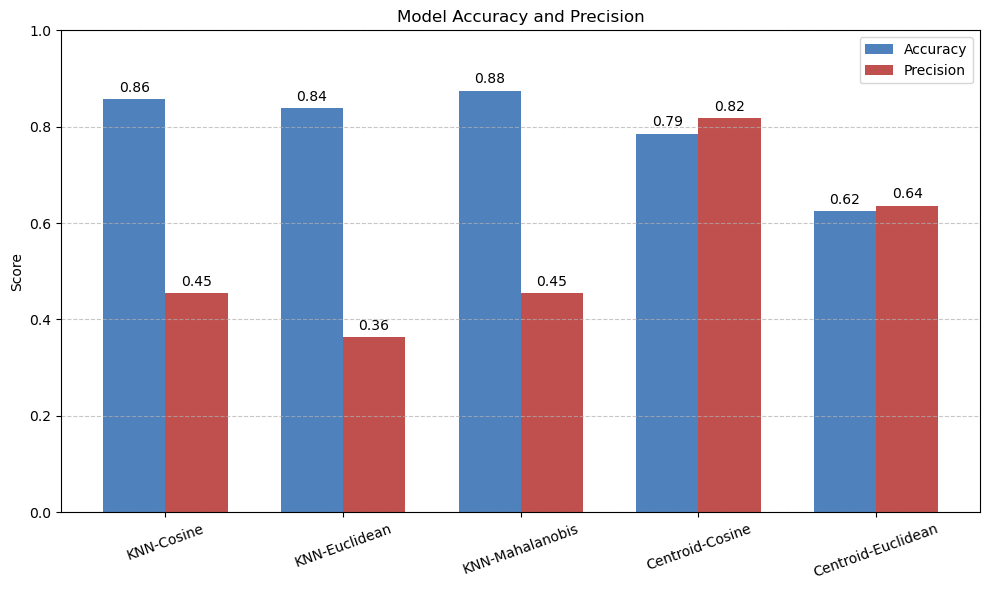

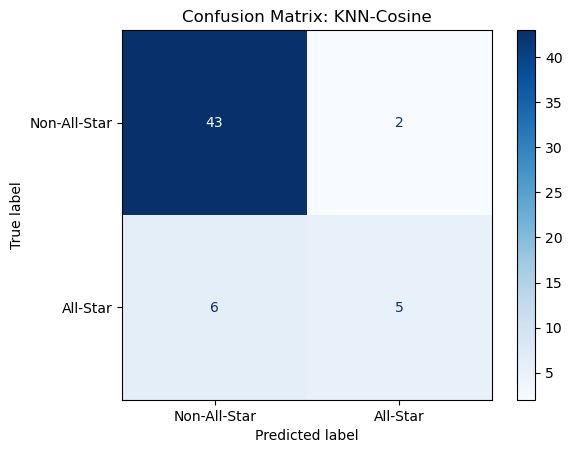

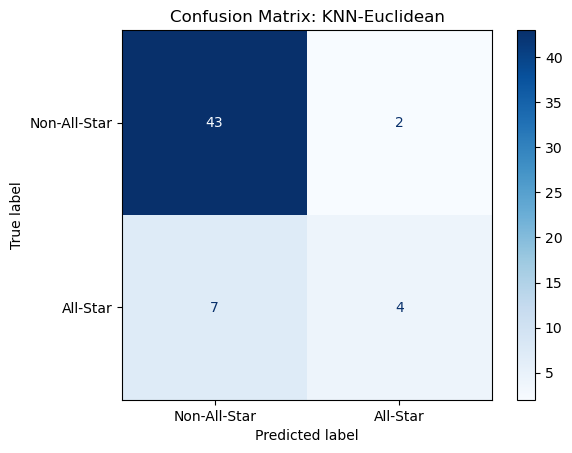

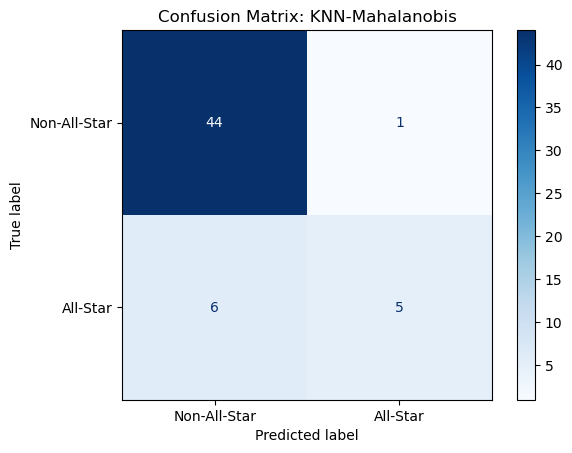

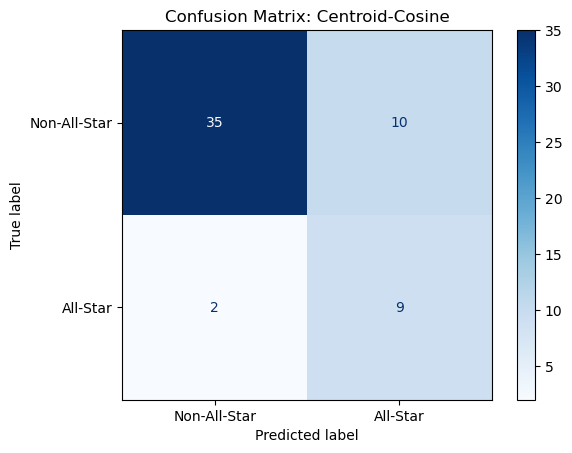

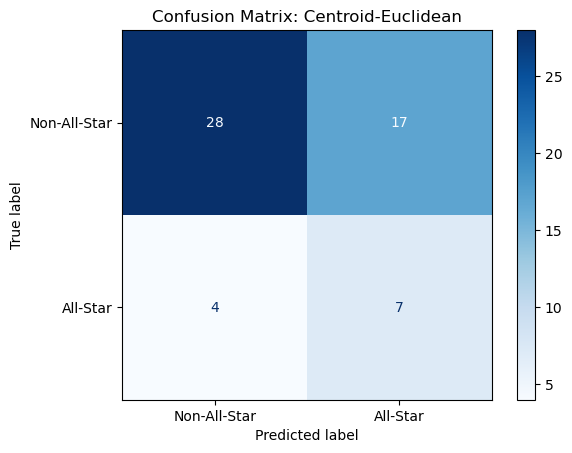

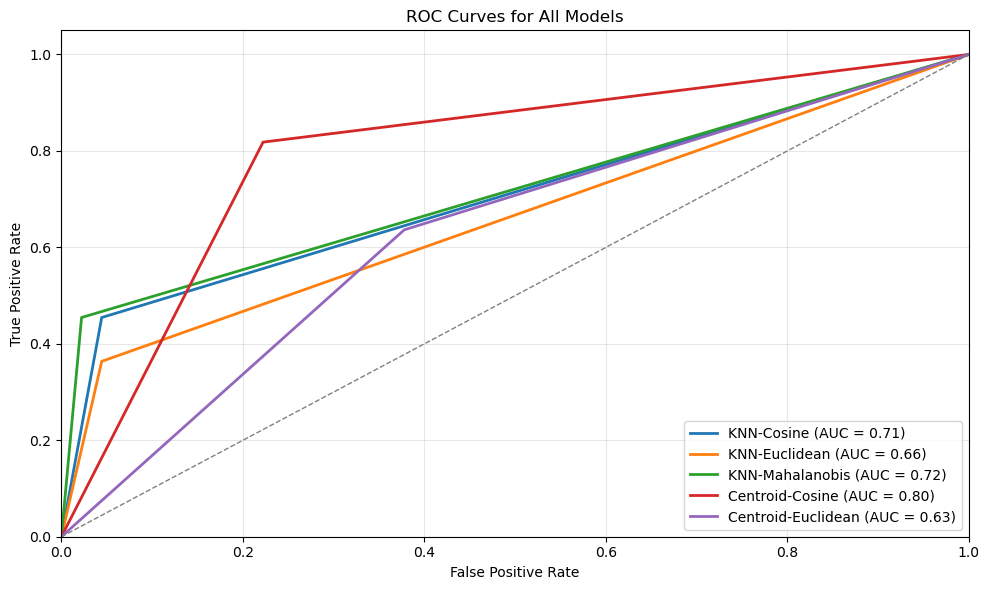

,Accuracy,Precision,Recall,F1-score
KNN-Cosine,0.86,0.71,0.45,0.56
KNN-Euclidean,0.84,0.67,0.36,0.47
KNN-Mahalanobis,0.88,0.83,0.45,0.59
Centroid-Cosine,0.79,0.47,0.82,0.60
Centroid-Euclidean,0.62,0.29,0.64,0.40


In [40]:
# Collect accuracy and precision results for visualization
model_names = [
    "KNN-Cosine", "KNN-Euclidean", "KNN-Mahalanobis",
    "Centroid-Cosine", "Centroid-Euclidean"
]

# For KNN, use k=3 results from previous cell (as an example)
k = 3
knn_cosine_pred = knn_prediction(x_train.values, y_train.values, x_test.values, k, 'cosine')
knn_euclidean_pred = knn_prediction(x_train.values, y_train.values, x_test.values, k, 'euclidean')
knn_mahalanobis_pred = knn_prediction(x_train.values, y_train.values, x_test.values, k, 'mahalanobis', cov_matrix)

# For centroid-based classifier
centroid_cosine_pred = centroid_classifier(x_train, y_train, x_test, 'cosine')
centroid_euclidean_pred = centroid_classifier(x_train, y_train, x_test, 'euclidean')

# Prepare lists for plotting
accuracies = [
    calculate_accuracy(list(y_test), knn_cosine_pred),
    calculate_accuracy(list(y_test), knn_euclidean_pred),
    calculate_accuracy(list(y_test), knn_mahalanobis_pred),
    calculate_accuracy(list(y_test), centroid_cosine_pred),
    calculate_accuracy(list(y_test), centroid_euclidean_pred)
]

precisions = [
    calculate_precision(list(y_test), knn_cosine_pred),
    calculate_precision(list(y_test), knn_euclidean_pred),
    calculate_precision(list(y_test), knn_mahalanobis_pred),
    calculate_precision(list(y_test), centroid_cosine_pred),
    calculate_precision(list(y_test), centroid_euclidean_pred)
]

predictions = [
    knn_cosine_pred,
    knn_euclidean_pred,
    knn_mahalanobis_pred,
    centroid_cosine_pred,
    centroid_euclidean_pred
]

x = np.arange(len(model_names))
width = 0.35

# --- Bar Chart with Value Labels ---
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='#4F81BD')
rects2 = ax.bar(x + width/2, precisions, width, label='Precision', color='#C0504D')

# Add value labels
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Score')
ax.set_title('Model Accuracy and Precision')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=20)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# --- Confusion Matrices ---
for name, pred in zip(model_names, predictions):
    cm = confusion_matrix(list(y_test), pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-All-Star", "All-Star"])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f'Confusion Matrix: {name}')
    plt.show()

# --- ROC Curves ---
plt.figure(figsize=(10, 6))
for name, pred in zip(model_names, predictions):
    fpr, tpr, _ = roc_curve(list(y_test), pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Metrics Table ---
metrics = []
for pred in predictions:
    precision, recall, f1, _ = precision_recall_fscore_support(list(y_test), pred, average='binary', zero_division=0)
    acc = calculate_accuracy(list(y_test), pred)
    metrics.append([acc, precision, recall, f1])

metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Precision', 'Recall', 'F1-score'], index=model_names)
display(metrics_df.style.format("{:.2f}").set_caption("Model Performance Summary"))
